In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, desc, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
#inspector
inspector = inspect(engine)
table_names = inspector.get_table_names()


In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with = engine)

# reflect the tables
measurement = Base.classes.measurement
station = Base.classes.station
Base.classes.keys()


['station', 'measurement']

In [7]:
# Save references to each table
columns = inspector.get_columns('station')
for col in columns:
    print (col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(desc(measurement.date)).first()

('2017-08-23',)

,year,precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01
...,...,...
2216,2017-08-17,0.13
2218,2017-08-19,0.09
2220,2017-08-21,0.56
2221,2017-08-22,0.50


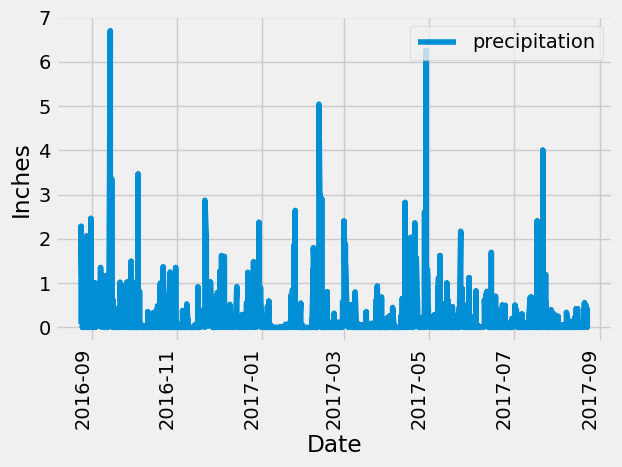

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
date = session.query(measurement.date).order_by(desc(measurement.date)).first()
dt.datetime.strptime(date[0], '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
past_year = dt.datetime.strptime(date[0], '%Y-%m-%d') - dt.timedelta(365)

# Perform a query to retrieve the data and precipitation scores
past_year_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= past_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(past_year_data, columns = ['year', 'precipitation'])
prcp_df['year'] = pd.to_datetime(prcp_df['year'])
prcp_df = prcp_df.dropna(how = 'any')

# Sort the dataframe by date
prcp_df.sort_values(by = 'year')

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x = 'year', y = 'precipitation', rot = 90,
             xlabel = 'Date',
             ylabel = 'Inches')
plt.legend(loc = 'upper right')
prcp_df


In [11]:
prcp_df.describe()['precipitation']

count    2015.000000
mean        0.176462
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
std         0.460288
Name: precipitation, dtype: float64

In [12]:
prcp_df['precipitation'].count()

2015

# Exploratory Station Analysis

In [13]:
columns = inspector.get_columns('station')
for col in columns:
    print (col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(measurement.station).distinct().count()

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(desc(func.count(measurement.station))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(desc(func.count(measurement.station))).first()
most_active_station[0]
session.query(measurement.station, func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == most_active_station[0]).all()
# session.query(station.name).filter(station.station == measurement.station[0]).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = most_active_station[0]
most_active_station_latest_date = session.query(measurement.date).order_by(desc(measurement.date)).filter(measurement.station == most_active_station[0]).first()
most_active_station_latest_date = dt.datetime.strptime(most_active_station_latest_date[0], '%Y-%m-%d')
most_active_station_past_year = most_active_station_latest_date - dt.timedelta(365)
most_active_station_past_year_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.date >= most_active_station_past_year).\
    filter(measurement.station == most_active_station[0]).all()
prcp_df = pd.DataFrame(most_active_station_past_year_data, columns = ['date', 'temp'])
prcp_df.values.tolist()
prcp_df['date'] = pd.to_datetime(prcp_df['date'])
tobs = {d:t for d, t in most_active_station_past_year_data}
tobs


{'2016-08-19': 79.0,
 '2016-08-20': 81.0,
 '2016-08-21': 79.0,
 '2016-08-22': 78.0,
 '2016-08-23': 77.0,
 '2016-08-24': 77.0,
 '2016-08-25': 80.0,
 '2016-08-26': 80.0,
 '2016-08-27': 75.0,
 '2016-08-28': 73.0,
 '2016-08-29': 78.0,
 '2016-08-30': 77.0,
 '2016-08-31': 78.0,
 '2016-09-01': 80.0,
 '2016-09-02': 80.0,
 '2016-09-03': 78.0,
 '2016-09-04': 78.0,
 '2016-09-05': 78.0,
 '2016-09-06': 73.0,
 '2016-09-07': 74.0,
 '2016-09-08': 80.0,
 '2016-09-09': 79.0,
 '2016-09-10': 77.0,
 '2016-09-11': 80.0,
 '2016-09-12': 76.0,
 '2016-09-13': 79.0,
 '2016-09-14': 75.0,
 '2016-09-15': 79.0,
 '2016-09-16': 78.0,
 '2016-09-17': 79.0,
 '2016-09-18': 78.0,
 '2016-09-19': 78.0,
 '2016-09-20': 76.0,
 '2016-09-21': 74.0,
 '2016-09-22': 77.0,
 '2016-09-23': 78.0,
 '2016-09-24': 79.0,
 '2016-09-25': 79.0,
 '2016-09-26': 77.0,
 '2016-09-27': 80.0,
 '2016-09-28': 78.0,
 '2016-09-29': 78.0,
 '2016-09-30': 78.0,
 '2016-10-01': 77.0,
 '2016-10-02': 79.0,
 '2016-10-03': 79.0,
 '2016-10-04': 79.0,
 '2016-10-05'

(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 54., 31.,  9.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <BarContainer object of 12 artists>)

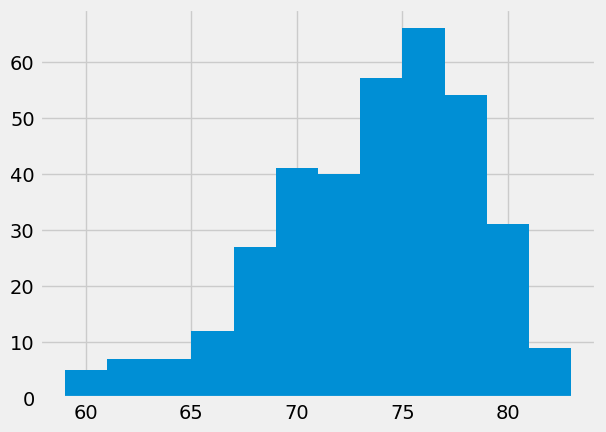

In [18]:
plt.hist(prcp_df['temp'], bins = 12, label='tobs')

# Close Session

In [19]:
# Close Session
session.close()